# 🧪🦍 Needle in a Jungle - Information Extraction via LLMs

<img src="https://haystack.deepset.ai/images/haystack-ogimage.png" width="430" style="display:inline;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<img src="https://github.com/ShishirPatil/gorilla/raw/gh-pages/assets/img/logo.png" width="250" style="display:inline;">

*Notebook by [Stefano Fiorucci](https://github.com/anakin87)*

In this experiment, we will use Large Language Models to perform Information Extraction from textual data.

🎯 Goal: create an application that, given a text (or URL) and a specific structure provided by the user, extracts information from the source.

The "**function calling**" capabilities of OpenAI models unlock this task: the user can describe a structure, by defining a fake function with all its typed and specific parameters. The LLM will prepare the data in this specific form and send it back to the user.

A nice example of using OpenAI Function Calling for information extraction is this [gist by Kyle McDonald](https://gist.github.com/kylemcdonald/dbac21de2d7855633689f5526225154c).

**What is changing now is that open models such as Gorilla are emerging, with function calling capabilities...**



**Stack**
- **[Gorilla OpenFunctions](https://github.com/ShishirPatil/gorilla/tree/main/openfunctions)**: an open-source model that formulates executable API/Function calls given natural language instructions and API/Function definition.
- **[Haystack](https://haystack.deepset.ai/)**: open-source LLM orchestration framework that streamlines the development of your LLM applications.

## Install the dependencies
`accelerate` and `bitsandbytes` are needed to load the model in a quantized version that runs smoothly on Colab.

In [ ]:
%%capture
! pip install transformers accelerate bitsandbytes haystack-ai trafilatura

## Load and try the model
We use the `HuggingFaceLocalGenerator`, which allows to locally load a model hosted on Hugging Face.
We also specify some quantization options to run the model with the limited resources offered by Colab. [An article about the HuggingFaceLocalGenerator on Haystack](https://haystack.deepset.ai/blog/guide-to-using-zephyr-with-haystack2).

A few notes:
- Although the model would be availaible in a free deployed version, with an OpenAI-compatible API, I decided not to use this option, as I found the server rather unstable.
- To load the model on Colab, I sharded it myself and published it on Hugging Face. To understand why you need a sharded version, you can read [this excellent article by Maarten Grootendorst](https://www.maartengrootendorst.com/blog/quantization/#2-sharding).

In [ ]:
import torch
from haystack.components.generators import HuggingFaceLocalGenerator

generator = HuggingFaceLocalGenerator("anakin87/gorilla-openfunctions-v0-sharded",
                                          huggingface_pipeline_kwargs={"device_map":"auto",
                                                                      "model_kwargs":{"load_in_8bit":True,
                                                                                    "torch_dtype":torch.float16}},
                                          generation_kwargs={"max_new_tokens":128,
                                                             "batch_size":16})
generator.warm_up()

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

To understand how to prompt the model, give a look at the [GitHub README](https://github.com/ShishirPatil/gorilla/tree/main/openfunctions#running-openfunctions-locally).
Later we will see how to better organize the prompt for our purpose.

In [ ]:
prompt="""USER: <<question>> Call me an Uber ride type \"Plus\" in Berkeley at zipcode 94704 in 10 minutes
<<function>> [    {
        "name": "Uber Carpool",
        "api_name": "uber.ride",
        "description": "Find suitable ride for customers given the location, type of ride, and the amount of time the customer is willing to wait as parameters",
        "parameters":  [{"name": "loc", "description": "location of the starting place of the uber ride"}, {"name":"type", "enum": ["plus", "comfort", "black"], "description": "types of uber ride user is ordering"}, {"name": "time", "description": "the amount of time in minutes the customer is willing to wait"}]
    }]

ASSISTANT: """

In [ ]:
print(generator.run(prompt=prompt))

{'replies': [' uber.ride(loc="berkeley", type="plus", time=10)']}


All good! ✅

## Prompt template and Prompt Builder

- The Prompt template to apply is model specific. In our case, we customize a bit the original prompt which is available on [GitHub](https://github.com/ShishirPatil/gorilla/tree/main/openfunctions#running-openfunctions-locally).
- In Haystack, the prompt template is rendered using the [Prompt Builder component](https://docs.haystack.deepset.ai/v2.0/docs/promptbuilder).

In [ ]:
from haystack.components.builders import PromptBuilder

prompt_template = """USER: <<question>> Extract data from the following text. START TEXT. {{docs[0].content|truncate(10000)}} END TEXT. <<function>> {{function}}

ASSISTANT: """

prompt_builder = PromptBuilder(template=prompt_template)

In [ ]:
# let's see if the Prompt Builder works properly

from haystack import Document
print(prompt_builder.run(docs=[Document(content="my fake document")], function="my fake function definition"))

{'prompt': 'USER: <<question>> Extract data from the following text. START TEXT. my fake document END TEXT. <<function>> my fake function definition\n\nASSISTANT: '}


Nice ✅

## Other Components

The following Components are required for the Pipeline we are about to create. However, they are simple and there is no need to customize and try them, so we can instantiate them directly during Pipeline creation.

- [LinkContentFetcher](https://docs.haystack.deepset.ai/v2.0/docs/linkcontentfetcher): fetches the contents of the urls you give it and returns a list of content streams.
- [HTMLToDocument](https://docs.haystack.deepset.ai/v2.0/docs/htmltodocument): converts HTML files to Documents.
- [DocumentJoiner](https://docs.haystack.deepset.ai/v2.0/docs/documentjoiner): join lists of Documents.
- [DocumentCleaner](https://docs.haystack.deepset.ai/v2.0/docs/documentcleaner): make text documents more readable.



## Define a custom Component to parse and visualize the result

The output of the model generation is a function call string.

We are going to create a simple Haystack Component to appropriately parse this string and create a nice HTML visualization.

For more information on Creating custom Components, see the [docs](https://docs.haystack.deepset.ai/v2.0/docs/custom-components).

In [ ]:
from haystack import component
from typing import List, Optional
import ast
import re

def val_to_color(val):
  """
  Helper function to return a color based on the type/value of a variable
  """
  if isinstance(val, list):
    return "#FFFEE0"
  if val is True:
    return "#90EE90"
  if val is False:
    return "#FFCCCB"
  return ""

@component
class FunctionCallParser:
  """
  A component that parses the function call string and creates a HTML visualization
  """
  @component.output_types(html_visualization=str)
  def run(self, replies:List[str]):

    func_call_str = replies[0].strip().replace('\n','')

    # sometimes the model output starts with "extract_data(type=text)..." or similar expressions
    # that can't be correctly parsed, so we remove this substring
    func_call_str=re.sub("type=[a-zA-Z]+\)?,?","",func_call_str)

    # sometimes the output is like this: "extract_data(..., properties={"date": "2022-01-01", ...})"
    if "properties={" in func_call_str:
      clean_json_str = func_call_str.split("properties=")[-1].strip(')')
      kwargs = ast.literal_eval(clean_json_str)
    else:
    # sometimes, it is a proper function call: "extract_data(date="2022-01-01", ...)"
      func_call=ast.parse(func_call_str).body[0].value
      kwargs = {arg.arg: ast.literal_eval(arg.value) for arg in func_call.keywords}

    # Convert data to HTML format
    html_content = '<div style="border: 1px solid #ccc; padding: 10px; border-radius: 5px; background-color: #f9f9f9;">'
    for key, value in kwargs.items():
        html_content += f'<p><span style="font-family: Cursive; font-size: 30px;">{key}:</span>'
        html_content += f'&emsp;<span style="background-color:{val_to_color(value)}; font-family: Cursive; font-size: 20px;">{value}</span></p>'
    html_content += '</div>'

    return {"html_visualization": html_content}

## Create an Information Extraction Pipeline

To combine the Components in an appropriate and reproducible way, we resort to Haystack Pipelines.
The syntax should be easily understood. You can find more infomation [in the docs](https://docs.haystack.deepset.ai/v2.0/docs/pipelines).

In [ ]:
from haystack import Pipeline
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.routers import DocumentJoiner
# in the future, the previous import will become:
# from haystack.components.joiners import DocumentJoiner

pipe = Pipeline()

pipe.add_component("fetcher", LinkContentFetcher())
pipe.add_component("converter", HTMLToDocument(extractor_type="KeepEverythingExtractor"))
pipe.add_component("joiner", DocumentJoiner())
pipe.add_component("cleaner", DocumentCleaner())
pipe.add_component("prompt_builder", prompt_builder)
pipe.add_component("generator", generator)
pipe.add_component("parser", FunctionCallParser())

pipe.connect("fetcher", "converter")
pipe.connect("converter", "joiner")
pipe.connect("joiner", "cleaner")
pipe.connect("cleaner.documents", "prompt_builder.docs")
pipe.connect("prompt_builder", "generator")
pipe.connect("generator", "parser")

Let's draw our Pipeline!

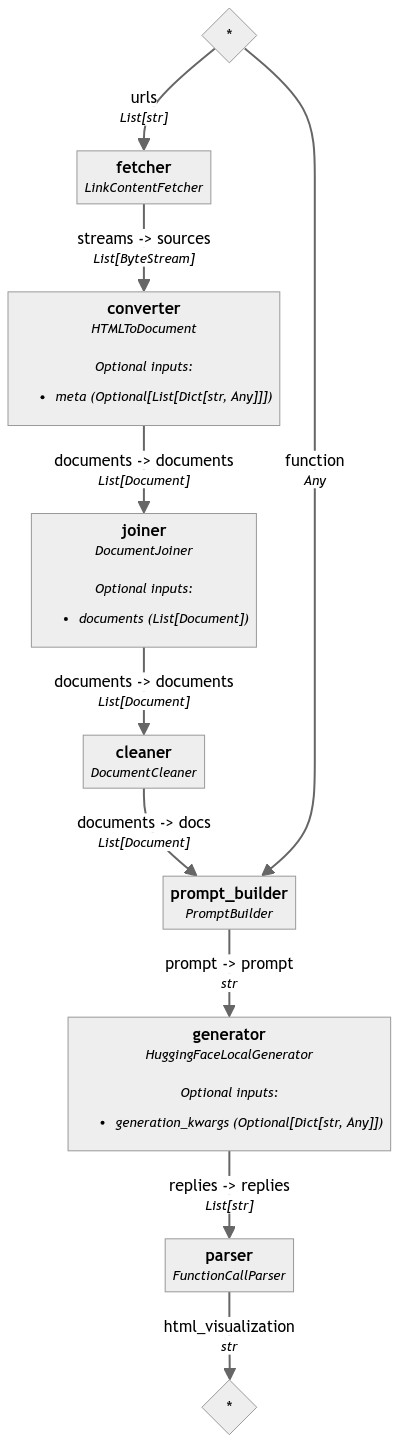

In [ ]:
from IPython.display import Image

pipe.draw('pipe.png')
Image('pipe.png')

Now we create an `extract` function that wraps the Pipeline.
This will accept:
- a `function` dict, containing the structure definition of the information we want to extract
- a `url` or a `text`, to use as data source

In [ ]:
from IPython.display import display, HTML

def extract(function:dict, url: Optional[str]=None, text: Optional[str]=None) -> dict:
  if not function:
    raise ValueError("function definition is needed")
  if not url and not text:
    raise ValueError("URL or text are needed")
  if url and text:
    raise ValueError("you should specify either a URL or a text")

  urls = []
  documents = []
  if url:
    urls.append(url)
  if text:
    documents.append(Document(content=text))

  generation_kwargs={"min_new_tokens":50, # this encourages the model to extract at least some information
                     "max_new_tokens":1000,
                     "batch_size":16}

  data_for_pipeline = {"fetcher":{"urls":urls},
                       "joiner":{"documents":documents},
                       "prompt_builder":{"function":function},
                       "generator": {"generation_kwargs": generation_kwargs}}

  html_visualization = pipe.run(data=data_for_pipeline)['parser']['html_visualization']
  display(HTML(html_visualization))

## 🕹️ Try our application!

Let's first define the structure to extract.

We are going to parse some articles about animals... 🦆🐻🦌

In [ ]:
function = {
    "name": "extract_data",
    "description": "Extract data from text",
    "parameters": {
        # "type": "object",  #  I found that the Gorilla model works better without this item
        "properties": {
            "about_animals": {
                "description": "Is the article about animals?",
                "type": "boolean",
            },
            "about_ai": {
                "description": "Is the article about artificial intelligence?",
                "type": "boolean",
            },
            "weight": {
                "description": "what is the weight of the animal in lbs?",
                "type": "integer",
            },
            "habitat": {
                "description": "List of places where the animal lives",
                "type": "array",
                "items": {"type": "string"},
            },
            "diet": {
                "description": "What does the animal eat?",
                "type": "array",
                "items": {"type": "string"},
            },
            "predators": {
                "description": "What are the animals that threaten them?",
                "type": "array",
                "items": {"type": "string"},
            },
        },
        "required": ["about_animals", "about_ai", "habitat", "diet", "predators"],
    },
}

Let's start with an article about **Capybaras**

In [ ]:
extract(function=function, url="https://www.rainforest-alliance.org/species/capybara/")

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


Now let's try with some text about the **Andean cock of the rock**
(from https://www.rainforest-alliance.org/species/cock-rock/)

In [ ]:
article="""Search for:\nAbout\nKnowledge Hub\nFor Individuals\nFor Business\nThe Latest\nDonate\nWork With Us\nSearch for:\nWhat our seal means\nWhat We Are Doing\nOur Impacts\nOur Approach\nIssues\nForests & Biodiversity\nLivelihoods\nClimate\nHuman rights\nRegions\nAsia\nCentral America & Mexico\nEast Africa\nSouth America\nWest & Central Africa\nWhat You Can Do\nSupport Our Work\nEveryday Actions\nFind the Frog\nSchool Curricula\nKids Games & Activities\nShop to Support\nFor Business\nCertification\nMarketing Sustainability\nTailored Supply Chain Services\nFor Partners\nAbout\nHelp Center\nThe Latest\nEvents\nWhat We Are Doing\nOur Impacts\nSee the positive change our work is making around the\n\t\t\t\t\t\tworld.\nLEARN\n\t\t\t\t\t\t\tMORE\nOur Approach\nIssues\nForests & Biodiversity\nLivelihoods\nClimate\nHuman\n\t\t\t\t\t\tRights\nRegions\nAsia\nEast\n\t\t\t\t\t\tAfrica\nWest\n\t\t\t\t\t\t& Central Africa\nSouth\n\t\t\t\t\t\tAmerica\nMexico\n\t\t\t\t\t\t& Central America\nWhat You Can Do\nSupport Our Work\nThere are many ways you can protect rainforests, fight\n\t\t\t\t\t\tclimate change, and help people and wildlife\n\t\t\t\t\t\tthrive.\nEXPLORE YOUR\n\t\t\t\t\t\t\tGIVING OPTIONS\nEveryday\n\t\t\t\t\t\tActions\nFind the Frog\nSchool\n\t\t\t\t\t\tCurricula\nKids’ Games\n\t\t\t\t\t\t& Activities\nShop to Support\nFor Business\nTransform your\n\t\t\t\t\t\tbusiness practices\nWhat Our Seal Means\nThe Rainforest Alliance certification seal means that the\n\t\t\t\t\t\tproduct (or a specified ingredient) was produced by\n\t\t\t\t\t\tfarmers, foresters, and/or companies working together to\n\t\t\t\t\t\tcreate a world where people and nature thrive in\n\t\t\t\t\t\tharmony.\nLEARN\n\t\t\t\t\t\t\tMORE\nDonate\nSpecies Profile\nCock-of-the-Rock\nRupicola peruviana\nLast updated on November 29, 2006\nCock-of-the-rock photo by\xa0Panegyrics of Granovetter\nPhoto credit: Panegyrics of Granovetter\nShare this...\nFacebook\nTwitter\nLinkedin\nEmail\nAnatomy\nA beautiful orange crest adorns the head of the cock-of-the-rock and brilliant orange, black and white feathers cover its back and wings. As with most birds, the female coloring is subtler. Their strong claws and legs allow them to grip onto steep cliffs and rocks.\nDid you know?\nForests are home to 80 percent of Earth\'s terrestrial biodiversity! We\'re preserving habitats for endangered species, conserving wildlife corridors, and saving breeding grounds. Please join our alliance to keep forests standing:\n"*" indicates required fields\nEmail*\nGDPR Consent\nYes, I agree to receive occasional emails from the Rainforest Alliance.\nHabitat\nFound in the Andes from Venezuela to Bolivia, the cock-of-the-rock lives only in mountainous regions and builds its nests on the rocky surfaces of cliffs, large boulders and caves.\nDiet\nThe cock-of-the–rock’s diet consists mainly of fruit. Often, these colorful birds do not digest the seeds of their fruity meals. Instead the seeds pass through their digestive tracks and are eventually scattered along the ground, making these birds extremely important seed dispersers. In addition to fruit, cocks-of-the-rock eat insects and small vertebrates.\nThreats\nMany predators are attracted to the cock-of-the-rock’s beautiful plumage. These include birds of prey such as eagles and hawks, puma and jaguars and even boa constrictors. The loss of habitat, predominantly from forestland being converted to farmland, is a major threat to the survival of this brilliant bird.\nSources\nJukofsky, Diane. Encyclopedia of Rainforests. Connecticut: Oryx Press, 2002.\nEcology Info\n“Cock of the Rock,” Houston Zoo website, 2007.\nPhoto by Veronica Muñoz\nTags:\nEnvironmental Curriculum for Schools\nHelp Conserve Forests And Restore Balance To Our Planet\nMake your gift go further (and greener) with a monthly pledge\nDonate\nConservation Status Least Concern\nType\nBirds\nFound In\nSouth America\nFact Often, these colorful birds do not digest the seeds of their fruity meals. Instead the seeds pass through their digestive tracks and are eventually scattered along the ground, making these birds extremely important seed dispersers.\nYou Might Also Like...\nSpecies Profile\nCerulean Warbler\nSpecies Profile\nAfrican Grey Parrot\nSpecies Profile\nScarlet Macaw\nSpecies Profile\nGreat Curassow\nFor Business\nTransform your business practices\nFor Supporters\nHelp us rebalance the planet\nFor Researchers\nSee how we measure our impacts\nFor Educators\nUse our conservation curricula in your classroom\nThe Rainforest Alliance is a 501(c)(3) Nonprofit registered in the US under EIN: 13-3377893.\nIn 2022, 75% of our income supported sustainability programs. Learn More »\nFollow Us\nFacebook\nInstagram\nLinkedIn\nTikTok\nYouTube\nSubscribe\nSign up for business updates or general updates\nFAQ\nPress\nFinancials\nCertification Documents\nCareers\nContact Us\n© Copyright 1987 - 2023, Rainforest Alliance | Privacy Policy | Cookie Policy\nRainforest Match Active\nDouble your impact against deforestation.\nAct now!\nGive today\nX\nHabitats Matter.\nYour gift helps protect vital forest habitats for wildlife.\nGive today\nX\nPeople & Forests\nSupport nature’s guardians. Act now.\nGive Support\nX\n"""

In [ ]:
extract(function=function, text=article)

Now, the **Yucatan Deer**!

In [ ]:
extract(function=function, url="https://www.rainforest-alliance.org/species/yucatan-deer/")

A completely different example, about AI...

In [ ]:
function = {
    "name": "extract_data",
    "description": "Extract data from text",
    "parameters": {
        "properties": {
            "date": {"type": "string", "format": "date"},
            "about_animals": {
                "description": "Is the article about animals?",
                "type": "boolean",
            },
            "about_ai": {
                "description": "Is the article about artificial intelligence?",
                "type": "boolean",
            },
            "people": {
                "type": "array",
                "description": "Please list the mentioned people",
                "items": {"type": "string"},
            },
            "summary": {
                "type": "string",
                "description": "Summarize what happened in one sentence.",
            },
            "required": ["date", "about_animals", "about_ai", "people", "summary"],
        }
    },
}


In [ ]:
extract(function=function, url="https://www.theverge.com/2023/11/22/23967223/sam-altman-returns-ceo-open-ai")

## ⚠️ Caveats and 🔮 future directions
- I found the model a bit unstable. Changing the function definition slightly can alter the extraction results and even lead to unparsable function calls.
- It would be nice to try other similar models, such as [NexusRaven](https://huggingface.co/Nexusflow/NexusRaven-V2-13B)
- Good open source generic models (not fine-tuned for function calling) should also be investigated ([Anyscale announcement on function calling using Mistral-7B-Instruct-v0.1](https://www.anyscale.com/blog/anyscale-endpoints-json-mode-and-function-calling-features))

## 📚 References
*Related to the experiment*
- [Haystack LLM framework](https://haystack.deepset.ai/)
- [Using OpenAI Function Calling for Information Extraction: gist by Kyle McDonald](https://gist.github.com/kylemcdonald/dbac21de2d7855633689f5526225154c)
- Gorilla OpenFunctions: [release post](https://gorilla.cs.berkeley.edu/blogs/4_open_functions.html) and [GitHub repository](https://github.com/ShishirPatil/gorilla/tree/main/openfunctions)

*Other interesting resources on the topic*
- [Instructor project: structured extraction in Python, powered by OpenAI's function calling api](https://jxnl.github.io/instructor/)
- [NexusRaven-V2: Surpassing GPT-4 for Zero-shot Function Calling](https://nexusflow.ai/blogs/ravenv2)